In [1]:
%load_ext autoreload

%autoreload 2

In [31]:
from prosit_t.eval import prosit_transformer_eval
import wandb
import tensorflow as tf
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os
from prosit_t.wandb_agent.train_utils import get_proteometools_data
from prosit_t.models import PrositTransformerV2
import pandas as pd
from dlomix.models import PrositIntensityPredictor

In [4]:
pio.renderers.default = "iframe"

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
data_config = {
    "dataset": "proteometools",
    "data_source": {
        "train": "/cmnfs/proj/prosit/Transformer/first_pool_train.parquet",
        "val": "/cmnfs/proj/prosit/Transformer/first_pool_test.parquet",
    },
    "fragmentation": "HCD",
    "batch_size": 1024,
    "seq_length": 30,
}

In [7]:
project_name = "transforming-prosit-first-pool"
run = wandb.init(project=project_name)

wandb: Currently logged in as: mamisashvili-lizi (prosit-compms). Use `wandb login --relogin` to force relogin


In [8]:
_, val_data = get_proteometools_data(data_config)

2023-09-26 15:04:59.735772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43640 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e2:00.0, compute capability: 8.6


In [9]:
artifact_path = "prosit-compms/transforming-prosit-first-pool/model-hardy-pine-74:v144"
transformer = PrositTransformerV2(seq_length=30,embedding_output_dim=64,num_heads=16,
        num_transformers=6, dense_dim_factor=4)
transformer = prosit_transformer_eval.load_model(run,artifact_path,transformer)

wandb:   5 of 5 files downloaded.  
2023-09-26 15:05:19.129835: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./artifacts/model-hardy-pine-74:v144: FAILED_PRECONDITION: artifacts/model-hardy-pine-74:v144; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [10]:
artifact_path_small = "prosit-compms/transforming-prosit-first-pool/model-swept-monkey-124:v80"
transformer_small = PrositTransformerV2(seq_length=30,embedding_output_dim=64,num_heads=8,
        num_transformers=6, dense_dim_factor=4)
transformer_small = prosit_transformer_eval.load_model(run,artifact_path_small,transformer_small)

wandb:   5 of 5 files downloaded.  
2023-09-26 15:05:39.642408: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./artifacts/model-swept-monkey-124:v80: FAILED_PRECONDITION: artifacts/model-swept-monkey-124:v80; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [11]:
num_batches = 600
batch_size = 1024

In [12]:
data_list = prosit_transformer_eval.dataset_to_list(val_data.take(num_batches))
df = pd.DataFrame(data_list)

In [13]:
df = prosit_transformer_eval.process_df(df)

In [14]:
transformer_loss = prosit_transformer_eval.compute_losses(transformer, val_data, num_batches, batch_size)

2023-09-26 15:06:28.093120: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A40" frequency: 1740 num_cores: 84 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 45760577536 bandwidth: 696096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 2s 2s/step


2023-09-26 15:06:28.756368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 14ms/step


In [20]:
df["Transformer_loss"] = transformer_loss

In [15]:
transformer_loss_small = prosit_transformer_eval.compute_losses(transformer_small, val_data, num_batches, batch_size)
df["TransformerSmall_loss"] = transformer_loss_small

1/1 [==============================] - 0s 19ms/step


2023-09-26 15:07:24.555547: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A40" frequency: 1740 num_cores: 84 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 45760577536 bandwidth: 696096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


In [16]:
baseline_path = "prosit-compms/transforming-prosit-first-pool/model-classic-star-15:v45"
baseline = PrositIntensityPredictor(seq_length=30,embedding_output_dim=16,
        recurrent_layers_sizes=(256, 512))
baseline = prosit_transformer_eval.load_model(run,baseline_path,baseline)

wandb:   4 of 4 files downloaded.  
2023-09-26 15:08:12.351947: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./artifacts/model-classic-star-15:v45: FAILED_PRECONDITION: artifacts/model-classic-star-15:v45; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [17]:
baseline_loss = prosit_transformer_eval.compute_losses(baseline, val_data, num_batches, batch_size)

1/1 [==============================] - 3s 3s/step


2023-09-26 15:08:15.517345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 14ms/step


In [18]:
df["Baseline_loss"] = baseline_loss

In [24]:
violin_sequence_length = prosit_transformer_eval.violin_plot_per_feature_val(
    df,
    ["Transformer_loss", "TransformerSmall_loss"],
    "sequence_length",
    title="Spectral Distance Stratified on Sequence Length",
    xaxis_title="Sequence Length",
    yaxis_title="Spectral_Distance"
)
violin_sequence_length.show()

In [25]:
violin_charge = prosit_transformer_eval.violin_plot_per_feature_val(
    df,
    ["Transformer_loss", "TransformerSmall_loss"],
    "precursor_charge_int",
    title="Spectral Distance Stratified on Precursor Charge",
    xaxis_title="Precursor Charge",
    yaxis_title="Spectral_Distance"
)
violin_charge.show()

In [26]:
violin_ce = prosit_transformer_eval.violin_plot_per_feature_val(
    df,
    ["Transformer_loss", "TransformerSmall_loss"],
    "collision_energy_range",
    title="Spectral Distance Stratified on Collision Energy Ranges",
    xaxis_title="Collision Energy Range",
    yaxis_title="Spectral Distance"
)
violin_ce.show()

In [33]:
charge_histograms_transformer = prosit_transformer_eval.histogram_per_feature_val(
    df,
    "Transformer_loss",
    "precursor_charge_int",
    2,
    3,
    title="Transformer: Histograms for Precursor Charge Groups",
    xaxis_title="Spectral Distance",
    yaxis_title="Count"
)
charge_histograms_transformer.show()

In [34]:
charge_histograms_baseline = prosit_transformer_eval.histogram_per_feature_val(
    df,
    "Baseline_loss",
    "precursor_charge_int",
    2,
    3,
    title="Baseline: Histograms for Precursor Charge Groups",
    xaxis_title="Spectral Distance",
    yaxis_title="Count"
)
charge_histograms_baseline.show()

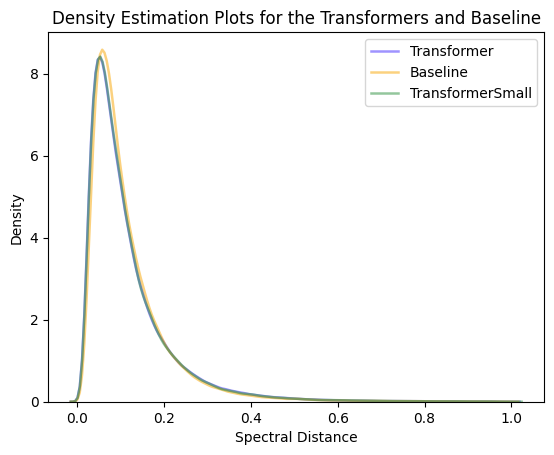

In [36]:
prosit_transformer_eval.kde_per_model(
    df,
    ["Transformer_loss", "Baseline_loss","TransformerSmall_loss"],
    title="Density Estimation Plots for the Transformers and Baseline",
    xaxis_title="Spectral Distance",
    yaxis_title="Density",
    colors=["#4028ff","#f8a500", "#288f3b"],
    alpha=0.5,
    fill=False,
    linewidth=1.8
)